Machine learning project checklist

    Define the problem and look at the big picture.
    Perform Exploratory Data Analysis (EDA) to gain insights.
    Clean and prepare data to better expose latent patterns within it.
    Explore many different machine learning models and pick the best ones.
    Perform model cross-validations to ensure that the analysis is robust.

# Contexto

A MaxMilhas conecta pessoas que curtem viajar com muito mais economia com aqueles que desejam vender milhas e faturar uma grana extra. Em 2017, transacionou mais de 5 bilhoes de milhas e mais de 500 mil passagens foram emitidas através da plataforma da empresa. O que torna esse número extremamente relevante para a utilizacao de ferramentas voltadas para o contexto de _Big Data_ e técnicas avancadas de Aprendizado de Máquina.

## 1. Hipóteses e Objetivos

A primeira etapa de um processo de ciência de dados, é levantar as perguntas ou hipóteses que serao investigadas, definir objetivos das análises que serao realizadas. Antes mesmo de tomar conhecimento dos dados que estao a nossa disposicao. Levantei 4 hipóteses que serao investigadas, baseadas no meu conhecimento sobre o negócio da MaxMilhas e que acredito que poderiam gerar um valor para o negócio, ou para mim como usuário da plataforma. Avaliei e classifiquei cada uma dessas hipóteses, em relacao a qual diretriz ela está também mais relacionada na minha visao. 

Ao final, uma dessas hipóteses será escolhida para que possamos criar um modelo de aprendizado de máquina que possa gerar algum retorno ou benefício para a empresa.

* **CLASSIFICACAO DE VOOS (Internacionais ou Domésticos)** - Com essa classificacao automática, poderíamos melhorar o fluxo da arquitetura de servicos de busca da MaxMilhas. Quem sabe, definindo diferentes instâncias do servico de buscas, uma responsável por cada classe buscada. Podendo, gerar uma economia de recursos ou melhorando o tempo de pesquisa dos voos.

    DIRETRIZ: SUPORTE A BUSCA


* **PREVISAO DE CANCELAMENTO DE VÔOS** - Baseado no histórico de voos reservados pela plataforma, poderíamos construir um algoritmo que pudesse prever, se determinado vôo tem chances de ser cancelado ou nao. Com isso, podemos sugerir aos usuários da plataforma, a reserva de um hotel ou hostel, por exemplo. Aumentando dessa forma o ticket médio gasto na plataforma, por usuário. Esse módulo, também poderia ser utilizado pelas companhias aéreas que poderiam, dessa forma antecipar problemas dessa natureza, e tomar medidas preventivas tanto em termos de _crew recovery_ ou _aircraft recovery_ como visando o passageiro também.
        
     DIRETRIZ: CONSTRUCAO DE MARCA E RELACIONAMENTO COM COMPANHIAS AEREAS


* **PREVISAO DE PRECOS DE VÔOS** - Baseado nos precos retornados pelas buscas em passagem aérea poderíamos construir uma primeira versao **(MVP)** de um modelo de regressao para previsao de precos de passagens, que nos fizesse recomendar ou aumentar o fluxo de usuários buscando passagens em épocas do ano, em que a quantidade de buscas na plataforma da MaxMilhas nao sao tao frequentes, aumentando dessa forma a taxa de utilizacao dos sistema.

     DIRETRIZ: SUPORTE E IMPULSAO DE BUSCA, CONSTRUCAO DE MARCA


* **SISTEMA DE RECOMENDACAO DE VOÔS NOTURNOS PARA VIAGENS INTERNACIONAIS COM CRIANCAS** - Nem sempre, o critério preco é mandatório para a experiência de viagem de uma família. Muitas vezes, o conforto e a qualidade da viagem é determinante na compra, podemos dessa forma identificar buscas que tem essa caracteristica no _dataset_ e realizar recomendacoes de voos, dentro da expectativa de datas, mas que seja mais agradável, principalmente para os pais e as criancas. Isso pode gerar também, a sugestao de outros produtos, como refeicao kids por parte das companhias aéreas ou kits como gibis, livros e etc- saindo do convencional entreterimento eletrônico de bordo. Vamos investigar se essa demanda se apresenta nesse dataset.

     DIRETRIZ: CONSTRUCAO DE MARCA E RELACIONAMENTO COM COMPANHIAS AEREAS

## 2. Leitura dos Dados e Análise Exploratória 

Os dados foram recebidos no formato .csv - e sim um _header_ apenas com o schema dos dados em um arquivo de imagem. Ao todo, temos **2.9 GB de dados**, e me parece ser mais razoável utilizar uma ferramenta que nos permita lidar com essa quantidade de dados ou maior ainda. Para carregar os dados, vamos utilizar o Apache Spark, em sua versao de API para o Python, chamada pySpark. 

Uma das limitacoes para que estao também relacionadas ao contexto do teste é que temos disponíveis apenas os dados entre **janeiro a marco de 2017**. Certamente isso prejudica nossa intencao em construir um modelo de regressao de precos de passagens já que nao temos dados suficiente para avaliar e confirmar tendências ou sazonalidades. 

In [18]:
from pyspark import SparkContext
from pyspark.sql.types import *                                   
from pyspark.sql import SparkSession                                     
import argparse

# Create spark Session                                                   
spark = SparkSession \
    .builder \
    .appName('MaxMilhas <> EDA') \
    .getOrCreate()  

In [21]:
input_path = '/home/leonardo/max-milhas/data/in/'

max_df = spark.read \
    .option("delimiter", ";") \
    .option("encoding", "ISO-8859-1") \
    .csv(input_path+"in.csv", 
         header=False, schema=schema)                                              

#Columns that could be dropped                                       
'''
columns_to_drop = ["idusers", "idsearch", "airport_dep_name", "aiport_arr_name", "airport_code_arr", 
"airport_code_dep", "direction"]
'''
#max_df = max_df.drop(*columns_to_drop) 

In [22]:
max_df.columns

['id',
 'idusers',
 'idsearch',
 'airline',
 'tipo_de_voo',
 'origin',
 'dest',
 'dep_date',
 'arr_date',
 'days_travelled',
 'adults',
 'childs',
 'infants',
 'dep_country',
 'arr_country',
 'international_flight',
 'direction',
 'class',
 'search_date',
 'wanted_dep_date',
 'wanted_arr_date',
 'search_received_date',
 'seconds_search',
 'seconds_to_results',
 'quant_flights',
 'quant_flights_received',
 'quant_best_price_airlines',
 'quant_best_price_mm',
 'cheapest_mm_price_dep',
 'cheapest_mm_price_arr',
 'airport_dep_name',
 'airport_code_dep',
 'airport_dep_combination',
 'airport_dep_group',
 'airport_arr_name',
 'airport_code_arr',
 'airport_arr_combination',
 'airport_arr_group']

In [16]:
len(max_df.columns)

36

In [26]:
from pyspark.sql.functions import col, count, isnan, lit, sum

def count_not_null(c, nan_as_null=False):
    """Use conversion between boolean and integer
    - False -> 0
    - True ->  1
    """
    pred = col(c).isNotNull() & (~isnan(c) if nan_as_null else lit(True))
    return sum(pred.cast("integer")).alias(c)

max_df.agg(*[count_not_null(c) for c in max_df.columns]).show()

+--------+-------+--------+--------+-----------+--------+--------+--------+--------+--------------+--------+--------+--------+-----------+-----------+--------------------+---------+--------+-----------+---------------+---------------+--------------------+--------------+------------------+-------------+----------------------+-------------------------+-------------------+---------------------+---------------------+----------------+----------------+-----------------------+-----------------+----------------+----------------+-----------------------+-----------------+
|      id|idusers|idsearch| airline|tipo_de_voo|  origin|    dest|dep_date|arr_date|days_travelled|  adults|  childs| infants|dep_country|arr_country|international_flight|direction|   class|search_date|wanted_dep_date|wanted_arr_date|search_received_date|seconds_search|seconds_to_results|quant_flights|quant_flights_received|quant_best_price_airlines|quant_best_price_mm|cheapest_mm_price_dep|cheapest_mm_price_arr|airport_dep_nam

A funcao acima calcula a quantidade de elementos nao-nulos em cada uma das colunas do nosso dataset, estamos verificando se o nossso _dataset_ nao possui problemas mais graves de _data quality_ que poderiam afetar o desempenho dos nossos algoritmos. 

A primeiro coisa a se notar, é o baixo número de buscas em que os usuários sao identificados (pouco mais que 10% do total), isso pode indicar que a grande maioria dos usuários nao se logam para realizar buscas. Isso poderia vir a ser uma _feature_ com duas classes (__BUSCA LOGADA e NAO LOGADA__). Temos também pouco mais da metade de registros nao nulos, para o campo __arr_date__ e __wanted_dep_date__

Partindo do princípio que cada linha do nosso dataset é uma busca diferente, vamos investigar quantas consultas únicas foram realizadas no período entre janeiro e marco de 2017

In [10]:
max_df.select('idsearch').distinct().describe().show()

+-------+--------------------+
|summary|            idsearch|
+-------+--------------------+
|  count|             4006380|
|   mean|2.0093743510875404E7|
| stddev|  1251788.7024110905|
|    min|            15123794|
|    max|            22938192|
+-------+--------------------+



In [11]:
max_df.select('idsearch', 'international_flight').describe().show()

+-------+-------------------+--------------------+
|summary|           idsearch|international_flight|
+-------+-------------------+--------------------+
|  count|           12434455|            12434455|
|   mean|2.012847695914039E7|                null|
| stddev| 1250891.8582730035|                null|
|    min|           15123794|                 NÃO|
|    max|           22938192|                 SIM|
+-------+-------------------+--------------------+



Isso parece indicar que apesar de termos mais de **12 milhoes de registros**, em termos de buscas únicas (idsearch) elas nao passam muito mais do que **4 milhoes de registros**. Mas ao que parece indicar, na pequena exibicao logo abaixo, é que uma mesma busca de passagem pode ser realizada para um ou mais companhias aéreas, o que faz bastante sentido para um buscador universal de precos de passagens.

In [36]:
max_df.select('idsearch', 'airline', 
              'tipo_de_voo','international_flight', 
              'quant_best_price_airlines', 'quant_best_price_mm').show()

+--------+-------+-----------+--------------------+-------------------------+-------------------+
|idsearch|airline|tipo_de_voo|international_flight|quant_best_price_airlines|quant_best_price_mm|
+--------+-------+-----------+--------------------+-------------------------+-------------------+
|17905536|   AZUL|  Ida/Volta|                 NÃO|                      0.0|                0.0|
|17905536|    GOL|  Ida/Volta|                 NÃO|                      0.0|                0.0|
|17905536|    TAM|  Ida/Volta|                 NÃO|                      0.0|                0.0|
|17905537|   AZUL|        Ida|                 NÃO|                      0.0|                0.0|
|17905538|    TAM|        Ida|                 NÃO|                      0.0|                0.0|
|17905538|   AZUL|        Ida|                 NÃO|                      0.0|                0.0|
|17905539|    TAM|  Ida/Volta|                 NÃO|                      0.0|                0.0|
|17905538|    GOL|  

In [29]:
max_df.sample(False, 0.03, 50).count()

373185

In [30]:
max_df.dtypes

[('id', 'string'),
 ('idusers', 'float'),
 ('idsearch', 'string'),
 ('airline', 'string'),
 ('tipo_de_voo', 'string'),
 ('origin', 'string'),
 ('dest', 'string'),
 ('dep_date', 'date'),
 ('arr_date', 'date'),
 ('days_travelled', 'int'),
 ('adults', 'int'),
 ('childs', 'int'),
 ('infants', 'int'),
 ('dep_country', 'string'),
 ('arr_country', 'string'),
 ('international_flight', 'string'),
 ('direction', 'string'),
 ('class', 'string'),
 ('search_date', 'date'),
 ('wanted_dep_date', 'date'),
 ('wanted_arr_date', 'date'),
 ('search_received_date', 'date'),
 ('seconds_search', 'int'),
 ('seconds_to_results', 'int'),
 ('quant_flights', 'int'),
 ('quant_flights_received', 'int'),
 ('quant_best_price_airlines', 'float'),
 ('quant_best_price_mm', 'float'),
 ('cheapest_mm_price_dep', 'string'),
 ('cheapest_mm_price_arr', 'string'),
 ('airport_dep_name', 'string'),
 ('airport_code_dep', 'string'),
 ('airport_dep_combination', 'string'),
 ('airport_dep_group', 'string'),
 ('airport_arr_name', 'st

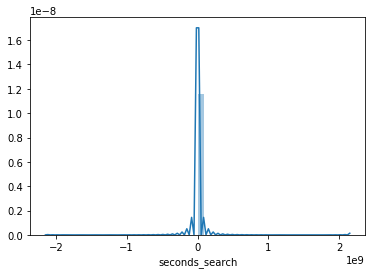

In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

columns_to_select = ['seconds_search', 
                     'seconds_to_results', 
                     'days_travelled',
                     'quant_flights_received',
                     'adults',
                     'childs'
                    ]

# Sample the dataframe
sample_max_df = max_df.select(columns_to_select).sample(False, 0.03, 50)

# Convert the sample to a Pandas Dataframe
pandas_df = sample_max_df.toPandas()
pandas_df = pandas_df.dropna()

sns.distplot(pandas_df['seconds_search'])

plt.show()

Parece que encontramos um padrao interessante aqui. O tempo de busca parece se comportar como uma **normal, centrada em 0**. O que é um característica que pode acabar favorecendo alguns algoritmos de aprendizado de máquina. Mas o que me deixa mais intrigado, é: como uma busca pode possuir valores de tempo menores que 0 ? Seria isso possível, ou existe algum erro na coleta desse dado ?

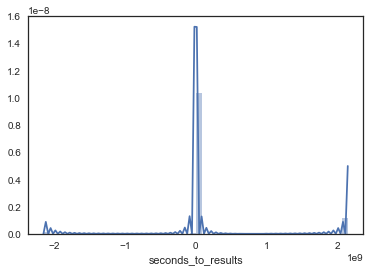

In [76]:
sns.set(style="white")

sns.distplot(pandas_df['seconds_to_results'])

plt.show()

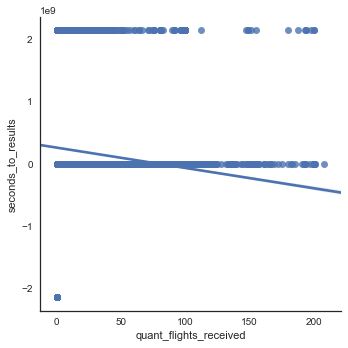

In [77]:
sns.lmplot(x='quant_flights_received', y='seconds_to_results', data=pandas_df)
plt.show()

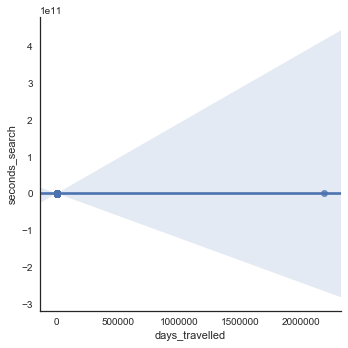

In [78]:
sns.lmplot(x='days_travelled', y='seconds_search', data=pandas_df)
plt.show()

O tempo de busca, nao parece ser influenciado de maneira direta pela quantidade de dias em que a viagem irá durar, nem pela quantidade de voos recebidos pela busca. O melhor seria que fizessemos um mapa de correlacao das variáveis com a variável de interesse (__seconds_search__).

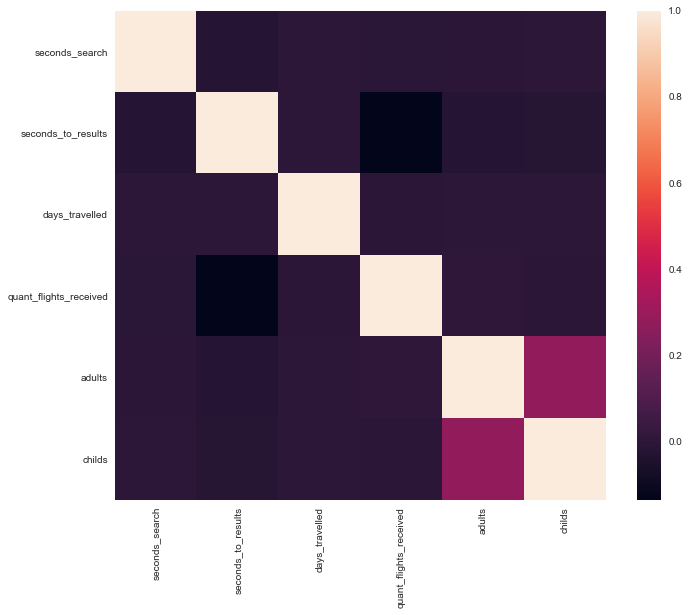

In [82]:
# Compute the correlation matrix
corr = pandas_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#            square=True, linewidths=.5, cbar_kws={"shrink": .5})

sns.heatmap(corr)
plt.show()

In [83]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35237 entries, 0 to 373184
Data columns (total 6 columns):
seconds_search            35237 non-null float64
seconds_to_results        35237 non-null float64
days_travelled            35237 non-null int32
quant_flights_received    35237 non-null float64
adults                    35237 non-null int32
childs                    35237 non-null int32
dtypes: float64(3), int32(3)
memory usage: 1.5 MB


In [72]:
pandas_df[pandas_df.seconds_search < 0].head()

,seconds_search,seconds_to_results,days_travelled,quant_flights_received,adults,childs
4330,-1.667818e+06,2.0,35,1.0,1,0
4451,-2.147484e+09,0.0,2,0.0,2,0
4511,-2.147484e+09,0.0,3,0.0,1,0
4523,-2.147484e+09,0.0,3,0.0,1,0
4665,-2.147484e+09,0.0,11,0.0,2,0


Curioso, que os valores que corresponde aos maiores valores